# Dive into time periods of change

This notebook is designed to further examine individual changepoints that occurred in [01_change_point_detection.ipynb](01_change_point_detection.ipynb).

In [1]:
from IPython import display
from pathlib import Path
import re

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import plydata as ply
import wordcloud

## Load the changepoint predictions

In [2]:
change_point_df = pd.read_csv("output/bayesian_changepoint_data.tsv", sep="\t")
change_point_df >> ply.slice_rows(10)

,tok,changepoint_prob,year_pair
0,!,0.020841,2000-2001
1,!,0.020878,2001-2002
2,!,0.029867,2002-2003
3,!,0.002951,2003-2004
4,!,0.110963,2004-2005
5,!,0.233036,2005-2006
6,!,0.093458,2006-2007
7,!,0.101725,2007-2008
8,!,0.103046,2008-2009
9,!,0.056640,2009-2010


## Load the word vector model and their indicies

In [3]:
word_models = list(Path("../multi_model_experiment/output/models").rglob("*/*model"))
word_models[0:2]

[PosixPath('../multi_model_experiment/output/models/2003/2003_0.model'),
 PosixPath('../multi_model_experiment/output/models/2003/2003_5.model')]

In [4]:
word_model_map = dict()
for word_model in word_models:
    match_obj = re.search(r"(\d+)_(\d).model", str(word_model))

    year = int(match_obj.group(1))
    if year not in word_model_map:
        word_model_map[year] = list()

    word_model_map[year].append(str(word_model))

In [5]:
word_model_loaded_map = {
    key: Word2Vec.load(sorted(word_model_map[key])[0]) for key in word_model_map
}

In [6]:
word_freq_count_cutoff = 30

In [7]:
word_model_cutoff_map = {
    key: {
        "model": word_model_loaded_map[key],
        "cutoff_index": min(
            map(
                lambda x: 999999
                if word_model_loaded_map[key].wv.get_vecattr(x[1], "count")
                > word_freq_count_cutoff
                else x[0],
                enumerate(word_model_loaded_map[key].wv.index_to_key),
            )
        ),
    }
    for key in word_model_loaded_map
}

# Examine Handpicked Tokens with a high chance of Change

In [8]:
def examine_words_at_timepoint_range(
    word_model_map: dict, years_to_examine: list, tok: str = "the", topn: int = 25
):
    for year in years_to_examine:
        print(year)
        display.display(
            word_model_map[year]["model"].wv.most_similar(
                tok, topn=topn, clip_end=word_model_map[year]["cutoff_index"]
            )
        )
        print()

## Pandemic

COVID-19. The drastic shift that came from the pandemic that was first talked about in 2019 but became more prevalent in 2020.

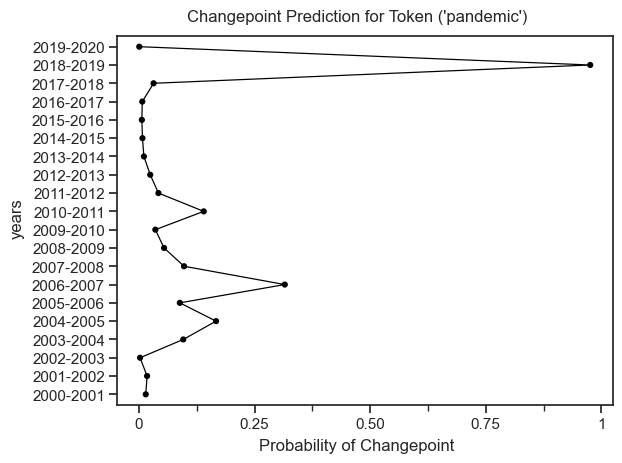

<ggplot: (8788477333743)>

In [9]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='pandemic'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="years",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('pandemic')",
    )
)

In [10]:
examine_words_at_timepoint_range(
    word_model_cutoff_map, [2017, 2018, 2019, 2020], tok="pandemic", topn=20
)

2017


[('pandemics', 0.6991780400276184),
 ('epidemic', 0.6856436729431152),
 ('epidemics', 0.6150782108306885),
 ('h7n9', 0.5978159308433533),
 ('outbreak', 0.5829018950462341),
 ('h5n1', 0.5636022686958313),
 ('outbreaks', 0.5613247156143188),
 ('h3n2', 0.5537860989570618),
 ('h1n1', 0.5487057566642761),
 ('influenza_virus', 0.5333134531974792),
 ('smallpox', 0.5245035290718079),
 ('influenza', 0.5225406289100647),
 ('h5n2', 0.5161430835723877),
 ('avian_influenza_virus', 0.514297604560852),
 ('reassortant', 0.5110467672348022),
 ('aivs', 0.4954032599925995),
 ('h5n6', 0.4929891526699066),
 ('hpai', 0.4925987720489502),
 ('reemergence', 0.4914324879646301),
 ('zika', 0.4908639192581177)]


2018


[('pandemics', 0.7332271933555603),
 ('epidemics', 0.6715065836906433),
 ('epidemic', 0.6519843935966492),
 ('1918', 0.6153443455696106),
 ('outbreaks', 0.5759876370429993),
 ('outbreak', 0.5730677247047424),
 ('h1n1', 0.541581392288208),
 ('influenza_infection', 0.5323501825332642),
 ('influenza', 0.5313560962677002),
 ('h7n9', 0.5313538908958435),
 ('influenza_virus', 0.5215354561805725),
 ('iavs', 0.5017030835151672),
 ('flu', 0.49690765142440796),
 ('h3n2', 0.4967515170574188),
 ('h5n1', 0.4835919141769409),
 ('ebola', 0.4784187972545624),
 ('hpai', 0.47480645775794983),
 ('vaccine', 0.4744572639465332),
 ('zika', 0.47367310523986816),
 ('vaccination', 0.4722369313240051)]


2019


[('epidemic', 0.6750437617301941),
 ('pandemics', 0.6453397870063782),
 ('epidemics', 0.6332555413246155),
 ('1918', 0.574148952960968),
 ('outbreak', 0.5280614495277405),
 ('outbreaks', 0.5235552787780762),
 ('hpai', 0.5136731266975403),
 ('h7n9', 0.5135642290115356),
 ('h1n1', 0.500178337097168),
 ('influenza', 0.48792916536331177),
 ('influenza_viruses', 0.48726943135261536),
 ('h3n2', 0.4749680757522583),
 ('aivs', 0.4734039604663849),
 ('h5n1', 0.469298392534256),
 ('h5n8', 0.468316912651062),
 ('chikungunya_virus', 0.4624755084514618),
 ('epizootic', 0.460426390171051),
 ('avian_influenza_virus', 0.4584755301475525),
 ('reassortant', 0.4581826627254486),
 ('emergence', 0.4580637216567993)]


2020


[('crisis', 0.7900959253311157),
 ('outbreak', 0.7101421356201172),
 ('pandemics', 0.686601459980011),
 ('epidemic', 0.6264187097549438),
 ('lockdown', 0.6042526364326477),
 ('surge', 0.5688024163246155),
 ('crises', 0.567150354385376),
 ('lockdowns', 0.5604577660560608),
 ('emergencies', 0.5471855998039246),
 ('redeployment', 0.5211671590805054),
 ('epidemics', 0.5193330645561218),
 ('spread', 0.5026978254318237),
 ('infodemic', 0.49901479482650757),
 ('situation', 0.49563202261924744),
 ('pandemia', 0.47866198420524597),
 ('neurosurgeons', 0.4780711233615875),
 ('outbreaks', 0.4773049056529999),
 ('surges', 0.4746277332305908),
 ('covid-19', 0.4732852578163147),
 ('humanity', 0.4658540189266205)]

## Rituximab

Not sure the change here but seems like the time period is when the drug was being used to treat rheumatoid arthritis. More investigation is needed.

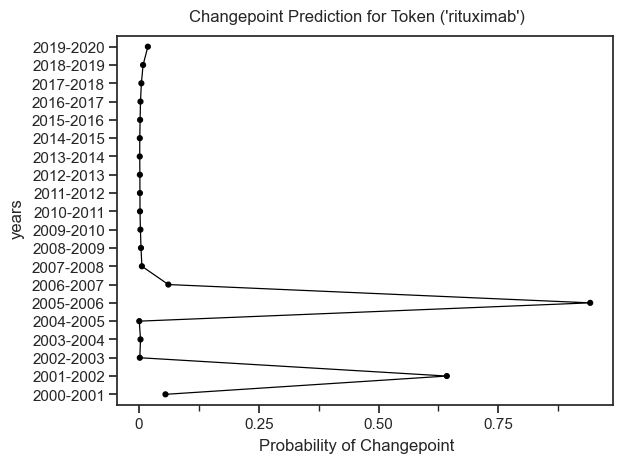

<ggplot: (8788476355304)>

In [37]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='rituximab'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="years",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('rituximab')",
    )
)

In [38]:
examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007],
    tok="rituximab",
    topn=20,
)

2000


[('mast', 0.6749982833862305),
 ('balb', 0.6679159998893738),
 ('parental', 0.637936532497406),
 ('clone', 0.6155112385749817),
 ('bearing', 0.6075371503829956),
 ('exhibited', 0.5965074896812439),
 ('transformed', 0.5959009528160095),
 ('gave', 0.5940744280815125),
 ('producing', 0.5791988372802734),
 ('-treated', 0.5764799118041992),
 ('cd34', 0.567865252494812),
 ('stimulates', 0.5668779015541077),
 ('peritoneal', 0.5657975077629089),
 ('mcf-7', 0.5619043707847595),
 ('enhances', 0.5521397590637207),
 ('colon_cancer', 0.5471397042274475),
 ('hematopoietic', 0.5470036864280701),
 ('mt', 0.546705961227417),
 ('w', 0.5428543090820312),
 ('stimulating', 0.5424321889877319)]


2001


[('transfer', 0.6426998376846313),
 ('kinetics', 0.6200207471847534),
 ('background', 0.6152129173278809),
 ('experiments', 0.6148674488067627),
 ('light', 0.6109252572059631),
 ('depends', 0.6017626523971558),
 ('shape', 0.5951443910598755),
 ('parallel', 0.5942104458808899),
 ('whole', 0.586495578289032),
 ('radial', 0.5810736417770386),
 ('monocytes', 0.5719237327575684),
 ('lateral', 0.5701507329940796),
 ('images', 0.5690827965736389),
 ('assays', 0.5648252367973328),
 ('separation', 0.5619150400161743),
 ('linking', 0.5612422823905945),
 ('cross', 0.557857871055603),
 ('depending', 0.5567417740821838),
 ('embryo', 0.5555033683776855),
 ('culture', 0.5538331866264343)]


2002


[('o', 0.7642405033111572),
 ('pacs', 0.7625166177749634),
 ('number(s', 0.7576115131378174),
 ('*', 0.7415123581886292),
 ('2.0', 0.7351735830307007),
 ('und', 0.7199195027351379),
 ('1.0', 0.7185031175613403),
 ('1.6', 0.7175909876823425),
 ('1.8', 0.703667938709259),
 ('ec', 0.6985718011856079),
 ('gm', 0.6965192556381226),
 ('doi:10.1038', 0.6928649544715881),
 ('transferase', 0.6864604353904724),
 ('mmhg', 0.6802101731300354),
 ('sj', 0.678193986415863),
 ('87', 0.6772534847259521),
 ('der', 0.675006628036499),
 ('des', 0.6717447638511658),
 ('10.1038', 0.6710097789764404),
 ('la', 0.6707950234413147)]


2003


[('systemic_lupus_erythematosus', 0.74424147605896),
 ('rheumatoid_arthritis', 0.7119893431663513),
 ('hepatitis', 0.6898559927940369),
 ('advanced', 0.6708577275276184),
 ('-associated', 0.6675217747688293),
 ('metastatic', 0.666694164276123),
 ('chemotherapy', 0.6639833450317383),
 ('docetaxel', 0.658749520778656),
 ('pancreatic_cancer', 0.657593846321106),
 ('colorectal_cancer', 0.6425361037254333),
 ('adjuvant', 0.6390045881271362),
 ('graft', 0.6336366534233093),
 ('malignancies', 0.6329132318496704),
 ('arthritis', 0.6276845335960388),
 ('agent', 0.619322657585144),
 ('endometriosis', 0.6150633096694946),
 ('autoimmunity', 0.6060788631439209),
 ('refractory', 0.6038910150527954),
 ('ra', 0.6034440994262695),
 ('transplantation', 0.6032803654670715)]


2004


[('i.', 0.7010663151741028),
 ('pacs', 0.6894559264183044),
 ('canine', 0.649408757686615),
 ('triglyceride', 0.6434385776519775),
 ('priming', 0.6400200724601746),
 ('0.03', 0.6295343637466431),
 ('p<0.05', 0.6221560835838318),
 ('alternate', 0.6217328906059265),
 ('3.8', 0.6121428608894348),
 ('glucocorticoids', 0.6115313768386841),
 ('neuroblastoma', 0.6065365076065063),
 ('pg', 0.6064301133155823),
 ('classic', 0.604299783706665),
 ('stably', 0.6029045581817627),
 ('suppresses', 0.6017924547195435),
 ('np', 0.5994503498077393),
 ('mumol', 0.5983171463012695),
 ('amoxicillin', 0.5952456593513489),
 ('conversely', 0.5951845645904541),
 ('bipolar', 0.5936198830604553)]


2005


[('refractory', 0.6044105291366577),
 ('symptomatic', 0.5961765050888062),
 ('methotrexate', 0.584784209728241),
 ('cyclophosphamide', 0.5593159198760986),
 ('prophylactic', 0.5532633662223816),
 ('immunosuppressive', 0.5436662435531616),
 ('thrombocytopenia', 0.5371777415275574),
 ('toxicities', 0.5331265330314636),
 ('vomiting', 0.5285472273826599),
 ('intravenous', 0.518385648727417),
 ('prolonged', 0.5166075229644775),
 ('adjuvant', 0.5117538571357727),
 ('imatinib', 0.5080980658531189),
 ('tolerated', 0.5068846344947815),
 ('autologous', 0.5058293342590332),
 ('regimens', 0.5054547190666199),
 ('subcutaneous', 0.5024641156196594),
 ('corticosteroids', 0.49930039048194885),
 ('neutropenia', 0.4969902038574219),
 ('withdrawal', 0.49486446380615234)]


2006


[('refractory', 0.6898175477981567),
 ('immunosuppressive', 0.6855635643005371),
 ('pegylated', 0.6717652678489685),
 ('cytotoxic', 0.6605305075645447),
 ('chemotherapeutic', 0.6598931550979614),
 ('bortezomib', 0.6457255482673645),
 ('doxorubicin', 0.6337072849273682),
 ('ribavirin', 0.6296496987342834),
 ('interferon', 0.6210818886756897),
 ('anti-', 0.6161273717880249),
 ('il-15', 0.6033083200454712),
 ('trastuzumab', 0.6002428531646729),
 ('adjuvant', 0.5989996790885925),
 ('relapsing', 0.5832734107971191),
 ('systemic_lupus_erythematosus', 0.5767406821250916),
 ('gefitinib', 0.5754924416542053),
 ('fluconazole', 0.5691105723381042),
 ('gemcitabine', 0.5684554576873779),
 ('platinum', 0.5634644627571106),
 ('paclitaxel', 0.5632907748222351)]


2007


[('refractory', 0.7421202063560486),
 ('relapsed', 0.6932263374328613),
 ('pdt', 0.6628113389015198),
 ('chemotherapy', 0.6389865875244141),
 ('5-fluorouracil', 0.6374110579490662),
 ('cyclophosphamide', 0.6331055760383606),
 ('bevacizumab', 0.6314488053321838),
 ('adjuvant', 0.6270129084587097),
 ('chemoradiation', 0.6111660599708557),
 ('docetaxel', 0.6103755235671997),
 ('5-fu', 0.6065484881401062),
 ('trastuzumab', 0.6063368320465088),
 ('cisplatin', 0.603394091129303),
 ('paclitaxel', 0.6017168164253235),
 ('imatinib', 0.5995900630950928),
 ('oxaliplatin', 0.597063422203064),
 ('chemotherapeutic', 0.5930866599082947),
 ('immunotherapy', 0.5919866561889648),
 ('irinotecan', 0.5759705901145935),
 ('carboplatin', 0.5732789039611816)]

## Asthma

There is semantic shift for asthma where in 2002-2003 seems like focus shifted from co-morbidity to drug treatments. Fun fact asthma is connected to type 2 diabetes (had no idea).

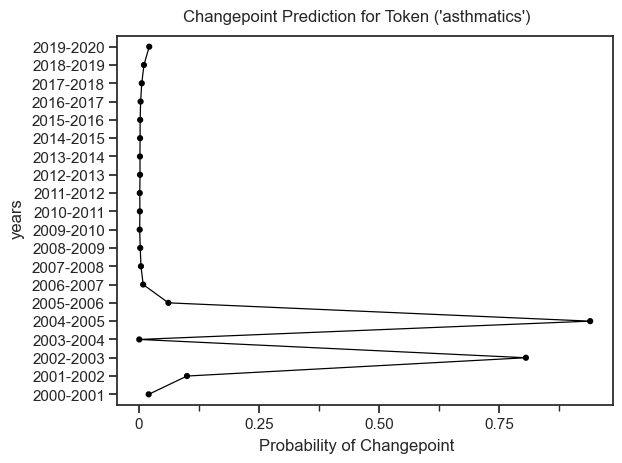

<ggplot: (8788476232950)>

In [39]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='asthmatics'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="years",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('asthmatics')",
    )
)

In [40]:
examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007],
    tok="asthmatics",
    topn=20,
)

2000


[('lungs', 0.7212653160095215),
 ('killed', 0.7005539536476135),
 ('peritoneal', 0.695019006729126),
 ('stomach', 0.6887806057929993),
 ('infiltration', 0.6834275126457214),
 ('joints', 0.6796582341194153),
 ('hepatic', 0.676683783531189),
 ('reactivity', 0.6741366386413574),
 ('c57bl/6', 0.673905611038208),
 ('cattle', 0.6665526032447815),
 ('healthy', 0.6612000465393066),
 ('-treated', 0.6528664231300354),
 ('bcg', 0.647591233253479),
 ('iga', 0.6475523114204407),
 ('mmc', 0.6473868489265442),
 ('untreated', 0.6473284363746643),
 ('vessel', 0.6436194777488708),
 ('calves', 0.6403672099113464),
 ('circulating', 0.6399605870246887),
 ('attenuated', 0.6387271881103516)]


2001


[('consistently', 0.7341912388801575),
 ('slightly', 0.6581230163574219),
 ('bilateral', 0.6499865651130676),
 ('ad', 0.6494346857070923),
 ('residual', 0.6403802633285522),
 ('progressive', 0.635447084903717),
 ('never', 0.6240246891975403),
 ('considerably', 0.6206234693527222),
 ('prevalent', 0.6187053918838501),
 ('distant', 0.6185603141784668),
 ('extra', 0.6060389280319214),
 ('mild', 0.6031607389450073),
 ('decreasing', 0.6027633547782898),
 ('gastroenteritis', 0.5927736163139343),
 ('venous', 0.5890352725982666),
 ('moderate', 0.588873565196991),
 ('correlate', 0.5871338844299316),
 ('p<0.05', 0.5837293863296509),
 ('parental', 0.5774109363555908),
 ('younger', 0.5771081447601318)]


2002


[('diabetes_mellitus', 0.6948237419128418),
 ('myocardial_infarction', 0.6515965461730957),
 ('mild', 0.6480078101158142),
 ('severe', 0.6354743242263794),
 ('condition', 0.6226110458374023),
 ('episodes', 0.6219514608383179),
 ('cough', 0.6160352230072021),
 ('symptoms', 0.6156531572341919),
 ('cigarette', 0.6154245138168335),
 ('sensitization', 0.5974223613739014),
 ('parents', 0.5956239104270935),
 ('infants', 0.5922144055366516),
 ('adolescents', 0.5916818976402283),
 ('elderly', 0.589257538318634),
 ('diarrhea', 0.5843044519424438),
 ('oa', 0.5814251899719238),
 ('excluded', 0.5793468356132507),
 ('child', 0.5763887166976929),
 ('hypertension', 0.5763483047485352),
 ('excess', 0.5744470357894897)]


2003


[('chemotaxis', 0.702450156211853),
 ('-based', 0.6793529391288757),
 ('trail', 0.6753236651420593),
 ('triggered', 0.6748639941215515),
 ('stimulates', 0.6636601686477661),
 ('inhibits', 0.6611665487289429),
 ('transforming', 0.6610868573188782),
 ('mediates', 0.6602891683578491),
 ('inhibiting', 0.6470538973808289),
 ('-mediated', 0.6423174738883972),
 ('inducing', 0.641094446182251),
 ('estrogens', 0.6351336240768433),
 ('catenin', 0.6270502805709839),
 ('integrin', 0.625895619392395),
 ('activates', 0.6258313059806824),
 ('osteoclast', 0.6237668395042419),
 ('ubiquitin', 0.621432363986969),
 ('src', 0.6211857795715332),
 ('modulates', 0.6209842562675476),
 ('axon', 0.6199256181716919)]


2004


[('inhaled', 0.6839941143989563),
 ('newborn', 0.6514480113983154),
 ('neonates', 0.6479457020759583),
 ('igg1', 0.6470595598220825),
 ('mild', 0.6405482292175293),
 ('asymptomatic', 0.6401692032814026),
 ('recipients', 0.627132773399353),
 ('vancomycin', 0.6207065582275391),
 ('calves', 0.6155859231948853),
 ('infliximab', 0.6147308945655823),
 ('moderate', 0.6107444167137146),
 ('donors', 0.6104379892349243),
 ('titer', 0.592126727104187),
 ('carriers', 0.5895813703536987),
 ('volunteers', 0.5851869583129883),
 ('transfusions', 0.5778705477714539),
 ('allergens', 0.5731098055839539),
 ('pg', 0.5730322003364563),
 ('smokers', 0.5715954303741455),
 ('titers', 0.5695578455924988)]


2005


[('atopic', 0.7547791004180908),
 ('sensitized', 0.7091889381408691),
 ('balf', 0.68149334192276),
 ('asthmatic', 0.6697232127189636),
 ('eosinophils', 0.6686051487922668),
 ('ova', 0.6626640558242798),
 ('sensitization', 0.648569643497467),
 ('bronchial', 0.6419340372085571),
 ('bronchoalveolar', 0.6368231773376465),
 ('allergens', 0.6330153942108154),
 ('lavage', 0.6224052906036377),
 ('airways', 0.5946694612503052),
 ('recipients', 0.5921541452407837),
 ('sputum', 0.5910604000091553),
 ('ige', 0.5881975293159485),
 ('allergen', 0.5849301218986511),
 ('allergic', 0.5832582712173462),
 ('ahr', 0.582333505153656),
 ('ventilated', 0.5822708606719971),
 ('infiltration', 0.5817573666572571)]


2006


[('asthmatic', 0.6221446990966797),
 ('airways', 0.6073458790779114),
 ('airway', 0.5993697047233582),
 ('neutrophils', 0.5845120549201965),
 ('lungs', 0.578845202922821),
 ('eosinophilia', 0.5696489214897156),
 ('bronchial', 0.5654510855674744),
 ('eosinophils', 0.5641201734542847),
 ('microglia', 0.5519346594810486),
 ('chronically', 0.5515621900558472),
 ('alveolar', 0.5485657453536987),
 ('spontaneously', 0.542661190032959),
 ('eosinophil', 0.5385617017745972),
 ('neutrophil', 0.5374373197555542),
 ('sputum', 0.5344828367233276),
 ('sepsis', 0.5313383340835571),
 ('respiratory_failure', 0.5266923308372498),
 ('allergen', 0.5219619870185852),
 ('macrophages', 0.5217006802558899),
 ('cutaneous', 0.5171064138412476)]


2007


[('airway', 0.6589729189872742),
 ('atopic', 0.6366866827011108),
 ('methacholine', 0.616245448589325),
 ('asthmatic', 0.5923959016799927),
 ('pulmonary', 0.5795917510986328),
 ('allergic', 0.5738620162010193),
 ('airways', 0.5672656297683716),
 ('asthma', 0.563923180103302),
 ('dyspnea', 0.5569828748703003),
 ('cough', 0.5476459264755249),
 ('elevation', 0.5461803078651428),
 ('eosinophils', 0.5442642569541931),
 ('systemic', 0.5440528392791748),
 ('hypotension', 0.543931245803833),
 ('respiratory_distress_syndrome', 0.543857991695404),
 ('allergen', 0.5431628227233887),
 ('atopy', 0.5374076962471008),
 ('corticosteroids', 0.5352861881256104),
 ('acth', 0.533117413520813),
 ('inhalation', 0.531807541847229)]

## Individual Year Changes

2001 token has a high chance of a shift moving from medical topics from cancer and healthcare to specifying time and dates.
This leads to the question do other years have this short of shift?
Turns out yes 2003 and 2004 have this shift but more data is needed in order to calculate the changepoint timeline (only used tokens present across all the years).

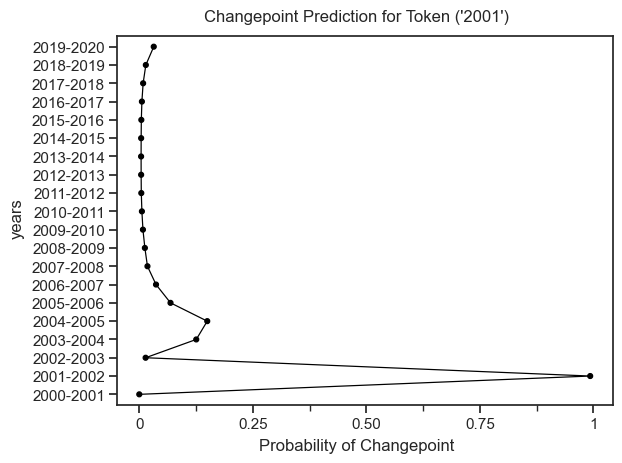

<ggplot: (-9223363248378148064)>

In [17]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='2001'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="years",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('2001')",
    )
)

In [18]:
examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007],
    tok="2001",
    topn=20,
)

2000


[('saudi', 0.8432109951972961),
 ('standardized', 0.8264970183372498),
 ('city', 0.8260639309883118),
 ('de', 0.8148120641708374),
 ('a.', 0.8061053156852722),
 ('materials', 0.7914955615997314),
 ('der', 0.7802072167396545),
 ('c.', 0.7777249813079834),
 ('mixed', 0.7755757570266724),
 ('1999', 0.7706924676895142),
 ('usa', 0.7677820920944214),
 ('medicare', 0.7641255259513855),
 ('electronic', 0.7600763440132141),
 ('personal', 0.7595586180686951),
 ('s.', 0.758797824382782),
 ('mercury', 0.7520304322242737),
 ('operations', 0.7516397833824158),
 ('consisted', 0.7497888207435608),
 ('1993', 0.7493039965629578),
 ('science', 0.7448055148124695)]


2001


[('http://www.bjcancer.com', 0.8318086266517639),
 ('campaign', 0.8302060961723328),
 ('cancer', 0.7477707266807556),
 ('research', 0.7422857880592346),
 ('campaignhttp://www.bjcancer.com', 0.7218648195266724),
 ('stroke', 0.5327287316322327),
 ('uk', 0.5237401723861694),
 ('breast_cancer', 0.5072314739227295),
 ('&', 0.49664217233657837),
 ('september', 0.49431484937667847),
 ('therapies', 0.484430193901062),
 ('prostate_cancer', 0.4801977276802063),
 ('malignancy', 0.475796103477478),
 ('society', 0.46949294209480286),
 ('regional', 0.4691867232322693),
 ('meeting', 0.4686853885650635),
 ('efforts', 0.467476487159729),
 ('bladder_cancer', 0.45329970121383667),
 ('healthcare', 0.452086865901947),
 ('aids', 0.4515453279018402)]


2002


[('july', 0.9446263313293457),
 ('2000', 0.9396282434463501),
 ('june', 0.931744396686554),
 ('usa', 0.923620343208313),
 ('1999', 0.9197708368301392),
 ('october', 0.9193089604377747),
 ('september', 0.9093526601791382),
 ('1996', 0.9075074195861816),
 ('canada', 0.9037778973579407),
 ('1998', 0.9028666019439697),
 ('1997', 0.900740921497345),
 ('december', 0.897705078125),
 ('april', 0.8972738981246948),
 ('january', 0.8956347703933716),
 ('1994', 0.8930555582046509),
 ('march', 0.8913734555244446),
 ('1995', 0.8765857815742493),
 ('meeting', 0.8738429546356201),
 ('society', 0.8639897108078003),
 ('university', 0.856545627117157)]


2003


[('2000', 0.9564700722694397),
 ('1999', 0.9534481167793274),
 ('december', 0.9512897729873657),
 ('1998', 0.9396007061004639),
 ('1997', 0.9351389408111572),
 ('1996', 0.9335981607437134),
 ('2002', 0.928378164768219),
 ('1992', 0.926242470741272),
 ('april', 0.9262280464172363),
 ('1995', 0.9234369397163391),
 ('1993', 0.9203662872314453),
 ('november', 0.9190138578414917),
 ('september', 0.9151549339294434),
 ('january', 0.9149354696273804),
 ('june', 0.9141809940338135),
 ('1994', 0.9102522134780884),
 ('july', 0.903495728969574),
 ('march', 0.899539589881897),
 ('canada', 0.8670191764831543),
 ('university', 0.860650897026062)]


2004


[('2002', 0.956555962562561),
 ('2000', 0.9546187520027161),
 ('1999', 0.9480164051055908),
 ('1998', 0.9414657950401306),
 ('1997', 0.9258561730384827),
 ('1996', 0.9090879559516907),
 ('1993', 0.9047948718070984),
 ('1995', 0.9004828929901123),
 ('june', 0.8955667018890381),
 ('october', 0.8923563957214355),
 ('1990', 0.8893294930458069),
 ('1991', 0.886691689491272),
 ('january', 0.8848327994346619),
 ('1992', 0.8846935033798218),
 ('july', 0.8830146789550781),
 ('2003', 0.868171751499176),
 ('february', 0.8680133819580078),
 ('city', 0.8669352531433105),
 ('march', 0.8612505793571472),
 ('december', 0.860803484916687)]


2005


[('2002', 0.9538552165031433),
 ('1999', 0.941307008266449),
 ('2000', 0.9353254437446594),
 ('1997', 0.9273191690444946),
 ('1992', 0.9255942106246948),
 ('1998', 0.9250929951667786),
 ('2003', 0.9164978861808777),
 ('1996', 0.9144657850265503),
 ('july', 0.8984336256980896),
 ('1995', 0.8974937200546265),
 ('1994', 0.8966698050498962),
 ('june', 0.8893527984619141),
 ('january', 0.8869908452033997),
 ('1991', 0.8797577023506165),
 ('september', 0.8776789307594299),
 ('october', 0.8750477433204651),
 ('1993', 0.8743531703948975),
 ('2004', 0.8661823868751526),
 ('1985', 0.8654690384864807),
 ('december', 0.8626788854598999)]


2006


[('2002', 0.9378804564476013),
 ('1999', 0.9193202257156372),
 ('1996', 0.9137009978294373),
 ('2000', 0.9060183763504028),
 ('1997', 0.9042595624923706),
 ('2004', 0.8884674310684204),
 ('1998', 0.8875961303710938),
 ('1994', 0.8816200494766235),
 ('1990', 0.8804488182067871),
 ('2003', 0.8791505694389343),
 ('1995', 0.8678397536277771),
 ('1993', 0.8618658781051636),
 ('1992', 0.8585325479507446),
 ('1989', 0.8532274961471558),
 ('1991', 0.8498894572257996),
 ('2005', 0.8408299088478088),
 ('1980', 0.8378196954727173),
 ('1988', 0.8333727717399597),
 ('december', 0.8287203311920166),
 ('january', 0.8280925750732422)]


2007


[('2003', 0.937782883644104),
 ('2002', 0.9260450601577759),
 ('2004', 0.9190454483032227),
 ('1999', 0.9123333692550659),
 ('1998', 0.9105551838874817),
 ('1996', 0.9097070693969727),
 ('2000', 0.9089395999908447),
 ('1997', 0.9066451787948608),
 ('1995', 0.9011654853820801),
 ('1994', 0.8847943544387817),
 ('2005', 0.8832452297210693),
 ('1992', 0.8814750909805298),
 ('1991', 0.8758801221847534),
 ('1993', 0.8726835250854492),
 ('1990', 0.8591752648353577),
 ('1985', 0.8538426160812378),
 ('2006', 0.8294625282287598),
 ('april', 0.8256270885467529),
 ('1988', 0.8208978772163391),
 ('1986', 0.8174721002578735)]

In [24]:
examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2001, 2002, 2003, 2004, 2005, 2006, 2007],
    tok="2002",
    topn=20,
)

2001


[('india', 0.8063188195228577),
 ('germany', 0.7984466552734375),
 ('netherlands', 0.7637784481048584),
 ('47', 0.747256338596344),
 ('eradication', 0.746081531047821),
 ('c.', 0.7437146306037903),
 ('black', 0.738354504108429),
 ('south', 0.7363499402999878),
 ('seeds', 0.7361745834350586),
 ('69', 0.736077070236206),
 ('52', 0.7354280948638916),
 ('japan', 0.7288751602172852),
 ('sweden', 0.7250351905822754),
 ('california', 0.7236170768737793),
 ('africa', 0.716462254524231),
 ('yr', 0.714867353439331),
 ('prenatal', 0.7140916585922241),
 ('0.04', 0.7114668488502502),
 ('63', 0.7105916738510132),
 ('april', 0.7073225975036621)]


2002


[('british_journal_of_cancer', 0.9454949498176575),
 ('87', 0.9204401969909668),
 ('doi:10.1038', 0.9092787504196167),
 ('86', 0.9069949984550476),
 ('doi', 0.8932250738143921),
 ('www.bjcancer.com', 0.8787106871604919),
 ('10.1038', 0.8739707469940186),
 ('j.', 0.8286666870117188),
 ('usa', 0.8217796087265015),
 ('sj', 0.8126808404922485),
 ('uk', 0.7999984622001648),
 ('conference', 0.7842532396316528),
 ('und', 0.7627854943275452),
 ('2001', 0.7586966156959534),
 ('la', 0.747410774230957),
 ('et', 0.7454637289047241),
 ('july', 0.7451778650283813),
 ('der', 0.7437066435813904),
 ('des', 0.7417592406272888),
 ('meeting', 0.7385398745536804)]


2003


[('april', 0.935422956943512),
 ('2001', 0.9283782243728638),
 ('september', 0.925445020198822),
 ('december', 0.9157528281211853),
 ('february', 0.9136343002319336),
 ('march', 0.9088101983070374),
 ('2000', 0.9079383015632629),
 ('november', 0.9059327840805054),
 ('october', 0.9050827622413635),
 ('1998', 0.8974112272262573),
 ('1992', 0.8915820717811584),
 ('1996', 0.8914527893066406),
 ('june', 0.8912656903266907),
 ('1999', 0.889941394329071),
 ('2003', 0.8876498937606812),
 ('january', 0.8817615509033203),
 ('july', 0.8788714408874512),
 ('usa', 0.8721766471862793),
 ('1995', 0.8637121915817261),
 ('1994', 0.8616956472396851)]


2004


[('2001', 0.956555962562561),
 ('1999', 0.9526932835578918),
 ('2000', 0.9288946986198425),
 ('1998', 0.9266785979270935),
 ('1997', 0.9237653613090515),
 ('july', 0.9225309491157532),
 ('june', 0.9086323380470276),
 ('october', 0.9023337960243225),
 ('2003', 0.9018549919128418),
 ('february', 0.8952934741973877),
 ('january', 0.8892712593078613),
 ('1993', 0.8866076469421387),
 ('march', 0.8853424191474915),
 ('april', 0.8851429224014282),
 ('november', 0.8795472979545593),
 ('1990', 0.8777859210968018),
 ('1995', 0.8673726320266724),
 ('december', 0.8654211759567261),
 ('1992', 0.8628286123275757),
 ('september', 0.8616975545883179)]


2005


[('2001', 0.9538552165031433),
 ('2000', 0.9413185715675354),
 ('2003', 0.9395217895507812),
 ('1998', 0.935455322265625),
 ('1999', 0.9293990135192871),
 ('1997', 0.9205735325813293),
 ('1992', 0.9123324751853943),
 ('1996', 0.9079698324203491),
 ('1994', 0.8988443613052368),
 ('1995', 0.885626494884491),
 ('july', 0.8823605179786682),
 ('1991', 0.8723043203353882),
 ('2004', 0.871273398399353),
 ('october', 0.8702239394187927),
 ('january', 0.8699345588684082),
 ('june', 0.8675122261047363),
 ('march', 0.8532117605209351),
 ('1993', 0.8531935811042786),
 ('december', 0.8521066308021545),
 ('1989', 0.8514293432235718)]


2006


[('2001', 0.9378805160522461),
 ('2000', 0.9242199063301086),
 ('2003', 0.9227199554443359),
 ('1999', 0.9218511581420898),
 ('1996', 0.9131659865379333),
 ('2004', 0.9080150723457336),
 ('1998', 0.9042612314224243),
 ('1994', 0.9004992842674255),
 ('1997', 0.8970680236816406),
 ('1995', 0.8804758191108704),
 ('1990', 0.8769423961639404),
 ('1993', 0.8750925064086914),
 ('2005', 0.855303943157196),
 ('1992', 0.8534585237503052),
 ('1980', 0.8513573408126831),
 ('1991', 0.8465787768363953),
 ('march', 0.8456258177757263),
 ('november', 0.8451701998710632),
 ('december', 0.844913899898529),
 ('1988', 0.8446298241615295)]


2007


[('2003', 0.9300655126571655),
 ('2001', 0.9260451197624207),
 ('1996', 0.9236549139022827),
 ('2000', 0.9162953495979309),
 ('2004', 0.9146245121955872),
 ('1997', 0.9092884659767151),
 ('1999', 0.9041351675987244),
 ('2005', 0.8994956016540527),
 ('1995', 0.8878554701805115),
 ('1998', 0.8872728943824768),
 ('1993', 0.8831503391265869),
 ('1992', 0.8810118436813354),
 ('1994', 0.8734124302864075),
 ('1985', 0.857234537601471),
 ('1990', 0.8536389470100403),
 ('1991', 0.8516843318939209),
 ('2006', 0.8271045088768005),
 ('november', 0.8148993849754333),
 ('1986', 0.8102503418922424),
 ('april', 0.8096151947975159)]

In [26]:
examine_words_at_timepoint_range(
    word_model_cutoff_map,
    [2001, 2002, 2003, 2004, 2005, 2006, 2007],
    tok="2003",
    topn=20,
)

2001


[('medicine', 0.8780555129051208),
 ('electronic', 0.8551231622695923),
 ('project', 0.8509266972541809),
 ('international', 0.8489315509796143),
 ('implemented', 0.8439934849739075),
 ('government', 0.8434041142463684),
 ('laboratories', 0.8415573239326477),
 ('program', 0.8333643674850464),
 ('society', 0.8331282734870911),
 ('services', 0.8328529000282288),
 ('reviews', 0.8269591331481934),
 ('programme', 0.8252877593040466),
 ('standards', 0.8241098523139954),
 ('conference', 0.8222143650054932),
 ('meeting', 0.8217001557350159),
 ('institute', 0.8203809261322021),
 ('scientists', 0.8189162015914917),
 ('national', 0.816405713558197),
 ('implementation', 0.8112483024597168),
 ('needs', 0.8081846833229065)]


2002


[('sought', 0.7000471949577332),
 ('discuss', 0.6552701592445374),
 ('workshop', 0.6441062092781067),
 ('papers', 0.6376475095748901),
 ('recommendations', 0.6354597210884094),
 ('believe', 0.6301151514053345),
 ('statistics', 0.6208488345146179),
 ('science', 0.6192717552185059),
 ('students', 0.6187579035758972),
 ('made', 0.6163511872291565),
 ('implemented', 0.6112954020500183),
 ('addressed', 0.6096375584602356),
 ('issues', 0.6060203909873962),
 ('advances', 0.6018872261047363),
 ('guidelines', 0.6008256077766418),
 ('private', 0.6008029580116272),
 ('questions', 0.5991829633712769),
 ('beginning', 0.5953621864318848),
 ('decisions', 0.5944299101829529),
 ('conducted', 0.5897355675697327)]


2003


[('usa', 0.9228909015655518),
 ('2002', 0.8876498937606812),
 ('february', 0.8662300109863281),
 ('october', 0.8619667887687683),
 ('june', 0.8513710498809814),
 ('conference', 0.8365359902381897),
 ('september', 0.8342829942703247),
 ('april', 0.8158129453659058),
 ('annual', 0.8099162578582764),
 ('spring', 0.8048946261405945),
 ('society', 0.7974013686180115),
 ('november', 0.7961088418960571),
 ('december', 0.7942329049110413),
 ('&', 0.7909618616104126),
 ('australia', 0.790335476398468),
 ('march', 0.7893681526184082),
 ('meeting', 0.7884358167648315),
 ('2001', 0.7855339050292969),
 ('college', 0.7779617309570312),
 ('uk', 0.7769067883491516)]


2004


[('march', 0.928215503692627),
 ('april', 0.9060505628585815),
 ('2002', 0.901854932308197),
 ('july', 0.8927509784698486),
 ('june', 0.8861556053161621),
 ('november', 0.884349524974823),
 ('september', 0.8760266304016113),
 ('2001', 0.8681718707084656),
 ('february', 0.8519372344017029),
 ('2004', 0.8477588295936584),
 ('2000', 0.8410372138023376),
 ('october', 0.831256628036499),
 ('hong', 0.830402672290802),
 ('1999', 0.8293284773826599),
 ('kong', 0.8265788555145264),
 ('january', 0.8185333013534546),
 ('taiwan', 0.8139671087265015),
 ('china', 0.8040578961372375),
 ('1997', 0.8017659187316895),
 ('france', 0.797909677028656)]


2005


[('2002', 0.9395217299461365),
 ('2001', 0.9164979457855225),
 ('july', 0.8938586711883545),
 ('1998', 0.892406702041626),
 ('2004', 0.8883048892021179),
 ('march', 0.8864219188690186),
 ('january', 0.8845809102058411),
 ('1999', 0.881694495677948),
 ('1997', 0.8810608983039856),
 ('2000', 0.876952052116394),
 ('1992', 0.8700794577598572),
 ('june', 0.867925763130188),
 ('1994', 0.8639615774154663),
 ('october', 0.8638278245925903),
 ('1996', 0.8605572581291199),
 ('1995', 0.8578177094459534),
 ('september', 0.8574187159538269),
 ('august', 0.8561694622039795),
 ('february', 0.8505076169967651),
 ('december', 0.8412885069847107)]


2006


[('2004', 0.9338700771331787),
 ('2002', 0.9227198362350464),
 ('2001', 0.8791506886482239),
 ('2005', 0.8677091002464294),
 ('2000', 0.8578751087188721),
 ('1996', 0.855333685874939),
 ('1999', 0.8533710241317749),
 ('november', 0.8508495092391968),
 ('1997', 0.8427935838699341),
 ('1998', 0.8378631472587585),
 ('1993', 0.8290247321128845),
 ('1994', 0.8287273049354553),
 ('february', 0.8149591684341431),
 ('1995', 0.8147850036621094),
 ('march', 0.8096376657485962),
 ('july', 0.8093154430389404),
 ('august', 0.8025539517402649),
 ('december', 0.7983813285827637),
 ('1980', 0.7967457175254822),
 ('january', 0.7954729795455933)]


2007


[('2001', 0.937782883644104),
 ('2002', 0.9300655126571655),
 ('2004', 0.9299824237823486),
 ('1996', 0.9243012070655823),
 ('2005', 0.9172598123550415),
 ('2000', 0.9135787487030029),
 ('1998', 0.9058120846748352),
 ('1997', 0.9009886384010315),
 ('1995', 0.8924322724342346),
 ('1999', 0.8840514421463013),
 ('1994', 0.8684614300727844),
 ('1992', 0.8671429753303528),
 ('1993', 0.8664298057556152),
 ('1990', 0.8549057841300964),
 ('1991', 0.8537904024124146),
 ('2006', 0.8444281220436096),
 ('november', 0.840759813785553),
 ('1985', 0.8324291110038757),
 ('april', 0.8205530643463135),
 ('march', 0.8128677010536194)]

# Take home points

1. Looks like my model is off by 1 for words such as corona virus and pandemic. This is probably due the way changepoint detection works and changes at the end of the series is hard to detect.
2. Asthma has an association with type 2 diabetes. Thats really interesting as I just hadn't fathomed there was a connection.
3. Years seem to undergo a shift in prevalent topics discussed to time indiciations. Need more data to be processed before I can truly say this trend is possible.
4. More data to come ones the years have finally finished processing.